# Project updates - *PlesioGeostroPy*

---

This notebook is an integral part of the `PlesioGeostroPy` project.

This notebooks serves as the notebook for regular updates.

In [39]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

from IPython.display import Image, display, Markdown
root_dir = "."

# The following 2 lines are a hack to import from parent directory
# If the notebook is run in the root directory, comment out these 2 lines
sys.path.append(os.path.dirname(os.getcwd()))
root_dir = ".."

from pg_utils.pg_model import core, base

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Choosing test functions

*Update 15/05/2024*

Background: we are solving the *reduced* system of equations in the Plesio-geostrophic system, in the form of:

In [40]:
Lin_op_psi = sym.Function(r"L_F")(core.pgvar_ptb.Psi)
Coriolis_psi = sym.Function(r"L_{Cor}")(core.pgvar_ptb.Psi)

display(sym.Eq(sym.diff(core.reduced_var.Psi, core.t), Coriolis_psi + core.reduced_var.F_ext))
display(sym.Eq(sym.diff(core.reduced_var.F_ext, core.t), Lin_op_psi))

Eq(Derivative(\psi(s, \phi, t), t), F_\mathrm{ext}(s, \phi, t) + L_{Cor}(\psi(s, \phi, t)))

Eq(Derivative(F_\mathrm{ext}(s, \phi, t), t), L_F(\psi(s, \phi, t)))

In the Galerkin method formulation, we form the weak form using the test function denoted as $\Psi^*$ and $F^*$:

In [41]:
from pg_utils.pg_model import expansion as xpd

Psi_test = sym.Function(r"\Psi^*")(core.s, core.p)
F_test = sym.Function(r"F^*")(core.s, core.p)

display(sym.Eq(
    xpd.InnerProduct1D(Psi_test, sym.diff(core.reduced_var.Psi, core.t), sym.S.One, core.s, sym.S.Zero, sym.S.One), 
    xpd.InnerProduct1D(Psi_test, Coriolis_psi + core.reduced_var.F_ext, sym.S.One, core.s, sym.S.Zero, sym.S.One)
))
display(sym.Eq(
    xpd.InnerProduct1D(F_test, core.reduced_var.F_ext, sym.S.One, core.s, sym.S.Zero, sym.S.One), 
    xpd.InnerProduct1D(F_test, Lin_op_psi, sym.S.One, core.s, sym.S.Zero, sym.S.One)
))

Eq(InnerProduct1D(\Psi^*(s, \phi), Derivative(\psi(s, \phi, t), t), 1, s, 0, 1), InnerProduct1D(\Psi^*(s, \phi), F_\mathrm{ext}(s, \phi, t) + L_{Cor}(\psi(s, \phi, t)), 1, s, 0, 1))

Eq(InnerProduct1D(F^*(s, \phi), F_\mathrm{ext}(s, \phi, t), 1, s, 0, 1), InnerProduct1D(F^*(s, \phi), L_F(\psi(s, \phi, t)), 1, s, 0, 1))

### Basis function

If regular solution exists, prior knowledge on the function space of $\Psi$ and $F$:
- $\Psi^m \sim O(s^{|m|})$ at the origin ($s=0$);
- $\Psi^m \sim O((1 - s^2)^{3/2})$ at the boundary ($s=1$);
- $F^m \sim O(s^{|m|+1})$ at the origin ($s=0$).

Hence the spectral expansion:
- $\Psi^m = s^{|m|} (1 - s^2)^{3/2} p(s^2)$;
- $F^m = s^{|m| + 1} p(s^2)$.

### Test function

We have some freedom as to what test functions to choose.

Different choices of $\Psi^*$ and $F^*$ yield (slightly) different convergence and results!

### Choice-1: the orthogonal basis

In [42]:
from pg_utils.pg_model import expand_stream_force_orth as xpd_cfg

display(Markdown("Basis functions:"))

display(sym.Eq(xpd_cfg.bases_s.Psi, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.Psi]))
display(sym.Eq(xpd_cfg.bases_s.F_ext, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.F_ext]))

display(Markdown("Test functions:"))

display(sym.Eq(xpd_cfg.test_s.Psi, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.Psi]))
display(sym.Eq(xpd_cfg.test_s.F_ext, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.F_ext]))

Basis functions:

Eq(\Phi_{\Psi}^{mn}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell, 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn}(s), s**(Abs(m) + 1)*jacobi(\ell, 0, Abs(m) + 1/2, 2*s**2 - 1))

Test functions:

Eq(\Phi_{\Psi}^{mn'}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell', 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn'}(s), s**(Abs(m) + 1)*jacobi(\ell', 0, Abs(m) + 1/2, 2*s**2 - 1))

The result is 

<table><tr>
<td> <img src="../out/eigen/Poloidal_Dipole/Reduced/mode-s_radial_m3n5_N80.png" alt="T1-QP" style="width: 1000px;"/> </td>
</tr></table>

### Choice-2: a *compact* expression

In [43]:
from pg_utils.pg_model import expand_stream_force_cpt as xpd_cfg

display(Markdown("Basis functions:"))

display(sym.Eq(xpd_cfg.bases_s.Psi, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.Psi]))
display(sym.Eq(xpd_cfg.bases_s.F_ext, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.F_ext]))

display(Markdown("Test functions:"))

display(sym.Eq(xpd_cfg.test_s.Psi, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.Psi]))
display(sym.Eq(xpd_cfg.test_s.F_ext, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.F_ext]))

Basis functions:

Eq(\Phi_{\Psi}^{mn}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell, 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn}(s), s**(Abs(m) + 1)*jacobi(\ell, 3/2, Abs(m), 2*s**2 - 1))

Test functions:

Eq(\Phi_{\Psi}^{mn'}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell', 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn'}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell', 3/2, Abs(m), 2*s**2 - 1))

The result is 

<table><tr>
<td> <img src="../out/eigen/Poloidal_Dipole/Reduced/mode-s_radial_m3n5_N80_cpt.png" alt="T1-QP" style="width: 1000px;"/> </td>
</tr></table>

### Choice-3: a *hybrid* expression

In addition to using different test functions, choices 1 and 2 also slightly modify the basis function for $F$ for orthogonality, although they both form the same function space.

The 3rd formulatio:
- basis function from choice 2
- test function from choice 1
- No longer diagonal mass matrix

In [33]:
from pg_utils.pg_model import expand_stream_force_hybrid as xpd_cfg

display(Markdown("Basis functions:"))

display(sym.Eq(xpd_cfg.bases_s.Psi, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.Psi]))
display(sym.Eq(xpd_cfg.bases_s.F_ext, xpd_cfg.recipe.base_expr[xpd_cfg.bases_s.F_ext]))

display(Markdown("Test functions:"))

display(sym.Eq(xpd_cfg.test_s.Psi, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.Psi]))
display(sym.Eq(xpd_cfg.test_s.F_ext, xpd_cfg.recipe.test_expr[xpd_cfg.test_s.F_ext]))

Basis functions:

Eq(\Phi_{\Psi}^{mn}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell, 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn}(s), s**(Abs(m) + 1)*jacobi(\ell, 3/2, Abs(m), 2*s**2 - 1))

Test functions:

Eq(\Phi_{\Psi}^{mn'}(s), s**Abs(m)*(1 - s**2)**(3/2)*jacobi(\ell', 3/2, Abs(m), 2*s**2 - 1))

Eq(\Phi_{F}^{mn'}(s), s**(Abs(m) + 1)*jacobi(\ell', 0, Abs(m) + 1/2, 2*s**2 - 1))

The result is 

<table><tr>
<td> <img src="../out/eigen/Poloidal_Dipole/Reduced/mode-s_radial_m3n5_N80_hybrid.png" alt="T1-QP" style="width: 1000px;"/> </td>
</tr></table>

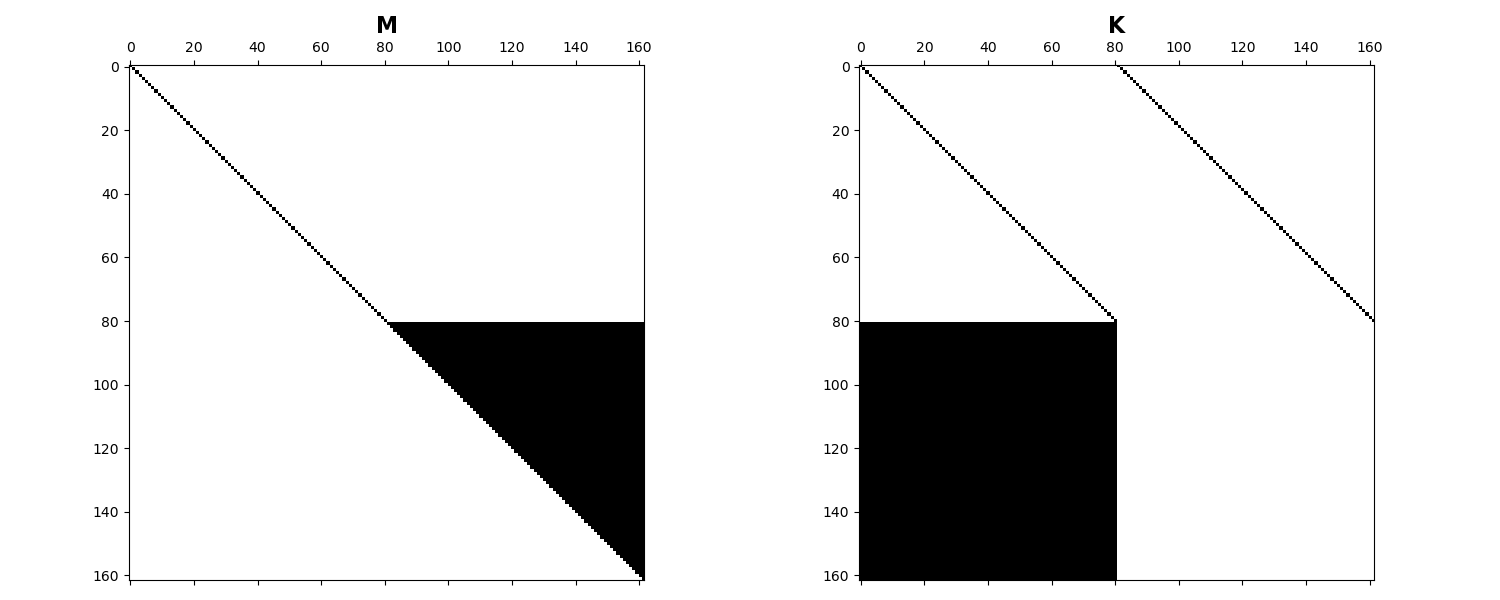

In [44]:
from pg_utils.numerics import io as num_io

matrix_file = "out/eigen/Poloidal_Dipole/Reduced/matrix_m3_Le1e-4_N80_p113_hybrid.h5"

with h5py.File(os.path.join(root_dir, matrix_file), 'r') as fread:
    M_tmp = num_io.matrix_load_from_group(fread["M"])
    K_tmp = num_io.matrix_load_from_group(fread["K"])
    if not isinstance(M_tmp, np.ndarray):
        M_tmp = M_tmp.todense()
        K_tmp = K_tmp.todense()

visual_prec = 1e-25
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

ax = axes[0]
ax.spy(M_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{M}$", fontsize=16)
# ax.set_xlim([700, 900])
# ax.set_ylim([900, 700])

ax = axes[1]
ax.spy(K_tmp, precision=visual_prec)
ax.set_title(r"$\mathbf{K}$", fontsize=16)

plt.tight_layout()
plt.show()